# Análise de Desempenho dos Estudantes com K-Means

Este notebook realiza uma análise de agrupamento (clustering) dos estudantes usando o algoritmo K-Means, seguindo o padrão do projeto KNN, para fins de comparação e estudo de técnicas não supervisionadas.

# 1. Importação das Bibliotecas

Utilizaremos pandas, numpy, matplotlib, seaborn e scikit-learn (KMeans, métricas de cluster).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 2. Carregamento do Dataset

O dataset utilizado é o mesmo do projeto KNN, contendo informações sobre desempenho de estudantes em exames.

In [17]:
import kagglehub

# Baixar o dataset do Kaggle
path = kagglehub.dataset_download("spscientist/students-performance-in-exams")
print("Path to dataset files:", path)

# Carregar o arquivo CSV
csv_path = path + "/StudentsPerformance.csv"
df = pd.read_csv(csv_path)
df.head()

Path to dataset files: C:\Users\ediad\.cache\kagglehub\datasets\spscientist\students-performance-in-exams\versions\1


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# 3. Análise Exploratória dos Dados

Verificação do formato, tipos de dados, valores nulos e estatísticas descritivas.

In [18]:
print('Formato do dataset:', df.shape)
df.info()
print('\nValores nulos por coluna:')
print(df.isnull().sum())
print('\nEstatísticas das notas:')
print(df[['math score', 'reading score', 'writing score']].describe())

Formato do dataset: (1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

Valores nulos por coluna:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score      

# 4. Visualização das Notas

Histogramas e boxplots para visualizar a distribuição das notas dos estudantes.

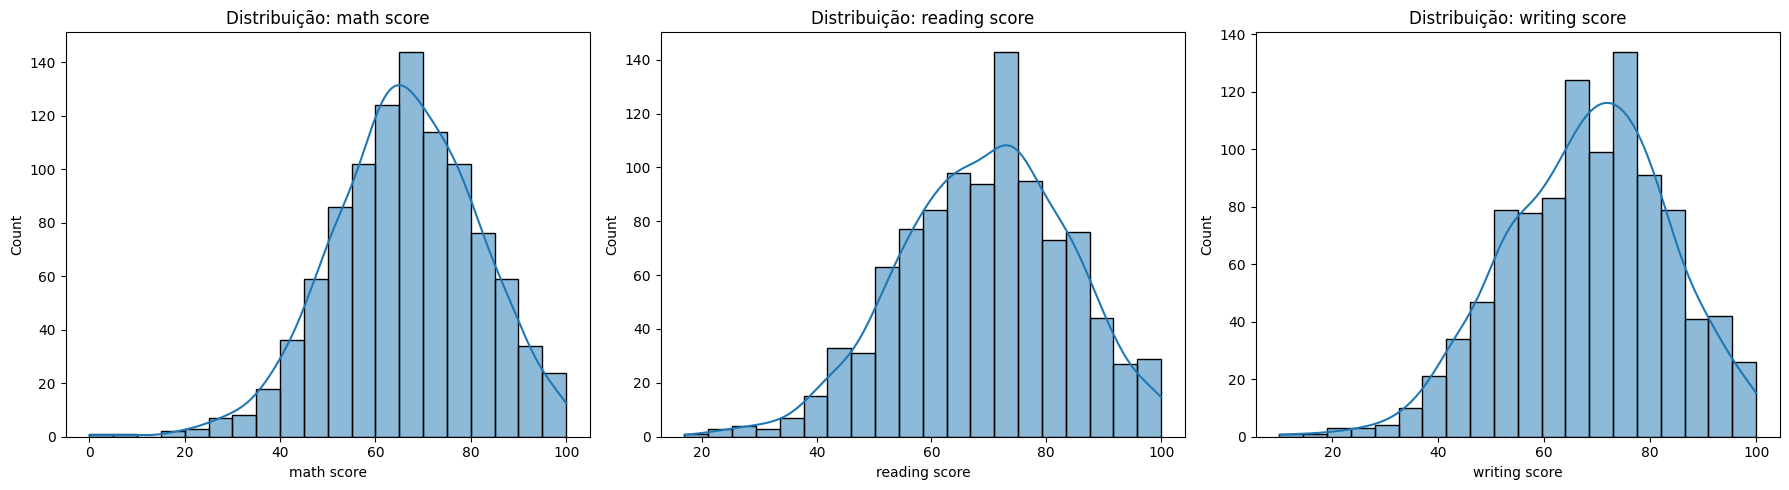

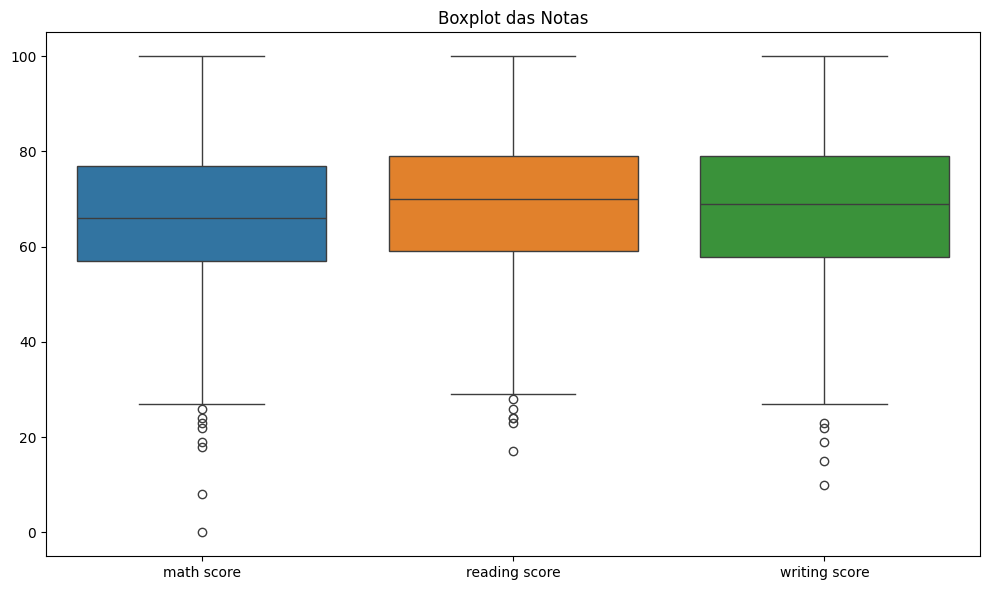

In [ ]:
import os
os.makedirs('imagens', exist_ok=True)

# Histogramas das notas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, col in enumerate(['math score', 'reading score', 'writing score']):
    sns.histplot(df[col], bins=20, ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribuição: {col}')
plt.tight_layout()
plt.show()
plt.close(fig)

# Boxplot das notas
fig2, ax2 = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df[['math score', 'reading score', 'writing score']], ax=ax2)
ax2.set_title('Boxplot das Notas')
plt.tight_layout()
plt.show()
plt.close(fig2)

# 5. Estatísticas das Notas e Interpretação

Análise estatística das notas dos estudantes, incluindo média, desvio padrão, valores mínimos e máximos.

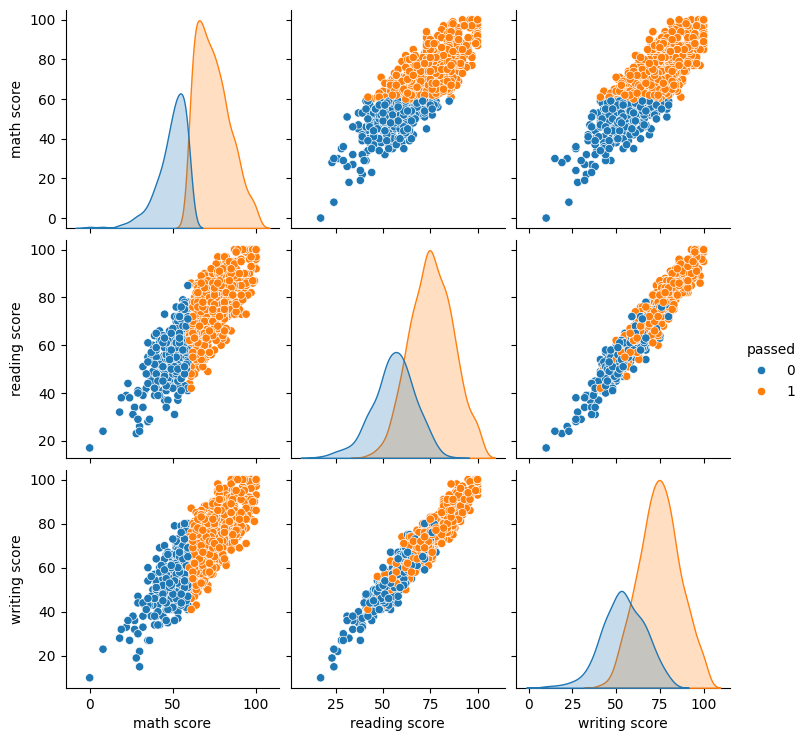

In [6]:
# Estatísticas já exibidas acima. Podemos complementar com visualização de pairplot para explorar relações.
if 'passed' not in df.columns:
    df['passed'] = (df['math score'] >= 60).astype(int)
sns.pairplot(df, hue='passed')
plt.savefig('imagens/pairplot_passed.png')
plt.show()

# 6. Pré-processamento dos Dados

Codificação de variáveis categóricas e normalização das variáveis numéricas para o K-means.

In [7]:
# Codificação das variáveis categóricas
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Normalização das variáveis numéricas
scaler = StandardScaler()
features = ['math score', 'reading score', 'writing score']
df_encoded[features] = scaler.fit_transform(df_encoded[features])
df_encoded.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,passed
0,0,1,1,1,1,0.390024,0.193999,0.391492,1
1,0,2,4,1,0,0.192076,1.427476,1.313269,1
2,0,1,3,1,1,1.577711,1.770109,1.642475,1
3,1,0,0,0,1,-1.259543,-0.833899,-1.583744,0
4,1,2,4,1,1,0.653954,0.605158,0.457333,1


# 7. Treinamento do Modelo K-Means

Aplicação do algoritmo K-means para agrupar os estudantes. O número de clusters será definido com base na análise exploratória e/ou métodos como o cotovelo (elbow method).

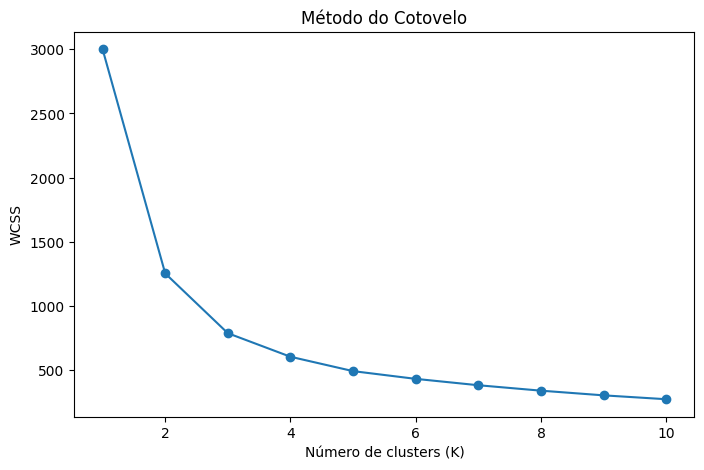

In [8]:
# Encontrando o número ideal de clusters (Elbow Method)
wcss = []
X = df_encoded[features]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.savefig('imagens/elbow_kmeans.png')
plt.show()

In [9]:
# Treinando o modelo K-means com o número de clusters escolhido (exemplo: 2)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
df_encoded['cluster'] = clusters
print('Centroides:', kmeans.cluster_centers_)

Centroides: [[ 0.64193588  0.69693431  0.68860025]
 [-0.81700931 -0.8870073  -0.87640031]]


# 8. Avaliação do Modelo K-Means

Avaliação dos clusters formados usando métricas como silhouette score e visualização dos agrupamentos.

Silhouette Score: 0.474


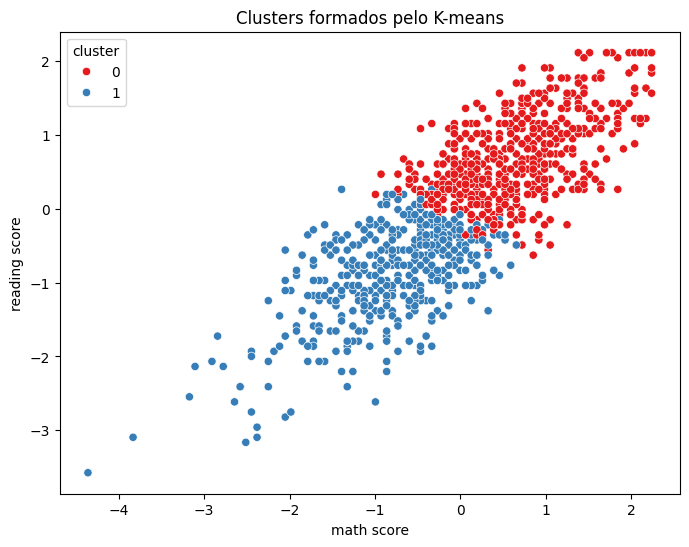

In [10]:
# Silhouette Score
sil_score = silhouette_score(X, clusters)
print(f'Silhouette Score: {sil_score:.3f}')

# Visualização dos clusters (usando duas notas para plot 2D)
plt.figure(figsize=(8,6))
sns.scatterplot(x='math score', y='reading score', hue='cluster', data=df_encoded, palette='Set1')
plt.title('Clusters formados pelo K-means')
plt.savefig('imagens/clusters_kmeans.png')
plt.show()

In [ ]:
# Heatmap de correlação entre as notas
plt.figure(figsize=(6,5))
corr = df[['math score', 'reading score', 'writing score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de Correlação das Notas')
plt.tight_layout()
plt.close()

In [11]:
# Gráfico: Média de matemática por cluster
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='cluster', y='math score', data=df_encoded, ci=None, ax=ax)
plt.title('Média de Matemática por Cluster')
plt.savefig('imagens/barplot_cluster.png')
plt.close()

# Gráfico: Distribuição dos clusters por grupo étnico
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(x='race/ethnicity', hue='cluster', data=df_encoded, ax=ax)
plt.title('Distribuição dos Clusters por Grupo Étnico')
plt.savefig('imagens/barplot_cluster_etnia.png')
plt.close()

C:\Users\ediad\AppData\Local\Temp\ipykernel_21328\3500883298.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cluster', y='math score', data=df_encoded, ci=None, ax=ax)


# 9. Relatório Final

Resumo dos resultados obtidos, análise dos clusters, possíveis melhorias e comparação com métodos supervisionados (KNN).